# Examples of using MultiTypeDBFE

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

import dbfe

In [2]:
pos_class = "RES"

stat_vals = pd.read_csv(f"../experiments/data/ovarian/ovarian_cnv.csv.gz", index_col='SAMPLEID')
stat_vals = dbfe.MultiTypeDBFE.stack(stat_vals)

labels = pd.read_csv(f"../experiments/data/ovarian/labels.tsv", sep='\t', index_col=0)
labels = (labels == pos_class) * 1 # NONRES == 0, RES == 1
stat_df = stat_vals.join(labels.CLASS_LABEL, how='inner')

stat_df

,DEL,DIP,DUP,CLASS_LABEL
CPCT02010646T,"[339068, 99019, 124463, 75553, 157365, 88249, ...","[962257, 10406281, 13655833, 9769046, 1698420,...","[112157, 226925, 43022, 16386872, 1884791, 827...",0
CPCT02010679T,"[28911668, 90828442, 174326, 162267, 30594, 77...","[424657, 616011, 3164446, 1492428, 78100947, 2...","[17809, 42219, 270049, 8206, 163855, 2850954, ...",0
CPCT02020307T,"[1776581, 124818, 716325, 7281449, 2640338, 36...","[95138969, 183318, 327962, 262492, 12654547, 6...","[814153, 415015, 1117398, 51851, 163586, 12519...",1
CPCT02020333T,"[767016, 1689640, 28817694, 28186777, 1394127,...","[1007103, 2346700, 10812054, 9209977, 63636, 5...","[1592143, 96680, 820662, 403062, 198447, 4325,...",1
CPCT02020420T,"[2366861, 10411937, 59616662, 44211, 13166450,...","[220359, 78549, 27949, 21380, 22371546, 732763...","[12339, 158656, 3106762, 1194489, 35373057, 63...",0
...,...,...,...,...
TCGA-36-1570-01A,"[37248, 198462, 11435934, 21717737, 7998166, 1...","[76719248, 64665329, 35278088, 3529203, 383958...","[7903273, 798619, 1332253, 21404042, 72966, 10...",1
TCGA-36-1571-01A,"[44211, 335207, 315813, 2516724, 631985, 15648...","[394319, 247404, 36703, 15994903, 29418394, 23...","[814153, 15955440, 91631, 8322778, 40846, 5457...",1
TCGA-36-1574-01A,"[26054, 10585377, 47714, 1990, 356342, 4932892...","[16803720, 283856, 3321260, 22405041, 5635980,...","[230970, 16251, 3962415, 31126264, 104694, 2, ...",1
TCGA-61-2000-01A,"[122287, 512304, 78553, 77328, 48860, 115082, ...","[5346245, 195933, 2357541, 43184057, 2990179, ...","[715045, 5184036, 2817815, 18009790, 611667, 6...",0


In [3]:
X = stat_df.drop("CLASS_LABEL", axis=1)
y = stat_df.loc[:, "CLASS_LABEL"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23, stratify=y)

## Basic usage

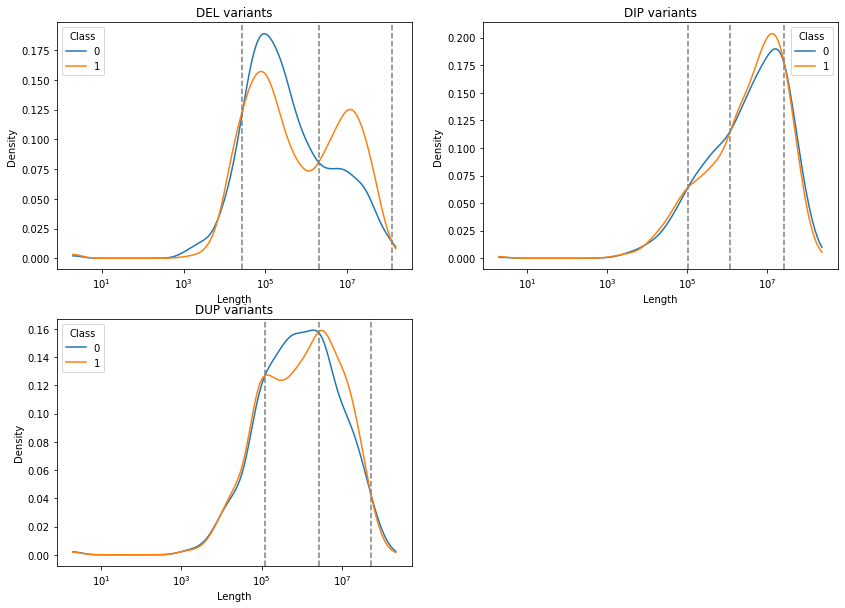

AUC on test data: 0.691


In [4]:
multi_extractor = dbfe.MultiTypeDBFE(breakpoint_type='supervised', n_bins='auto')
pipe = make_pipeline(multi_extractor, StandardScaler(), LogisticRegression())
pipe.fit(X_train, y_train)

plt.rcParams['figure.figsize'] = [14, 10]
multi_extractor.plot_data_with_breaks(X_train, y_train, plot_type='kde');

y_prob = pipe.predict_proba(X_test)
print("AUC on test data: {:.3}".format(roc_auc_score(y_test, y_prob[:, 1])))

## More complicated example

In [5]:
#this parameter can be used to perform DBFE only on selected columns
dbfe_cols = ['DUP', 'DEL', 'DIP']

custom_dbfe_args = {
    'DUP': dict(
        breakpoint_type='supervised',
        n_bins='auto'
    ),
    'DEL': dict(
        breakpoint_type='quantile',
        n_bins=10, 
    ),
    'DIP': dict(
        bins = [(0, 40000), (40000, 1000000), (1000000, np.inf)]
    )
}

tmp_extractor = dbfe.MultiTypeDBFE(dbfe_cols=dbfe_cols, custom_dbfe_args=custom_dbfe_args)
tmp_extractor.fit_transform(X_train, y_train)

NameError: name 'np' is not defined

In [ ]:
extractor = dbfe.MultiTypeDBFE(dbfe_cols=dbfe_cols, custom_dbfe_args=custom_dbfe_args)
pipe = make_pipeline(extractor, StandardScaler(), RandomForestClassifier(random_state=23))
pipe.fit(X_train, y_train)

plt.rcParams['figure.figsize'] = [14, 10]
extractor.plot_data_with_breaks(X_train, y_train, plot_type='kde');

y_prob = pipe.predict_proba(X_test)
print("AUC on test data: {:.3}".format(roc_auc_score(y_test, y_prob[:, 1])))